Explorar distribuição da variável churn depois que ela foi transformada pra inteiro

In [71]:
from pyspark.sql import SparkSession
from pyspark.sql.types import Row, IntegerType
from pyspark.sql.functions import col, udf, when
import pandas as pd
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# Spark Session
spSession = SparkSession.builder.master("local").appName("DSA-Projeto04").getOrCreate()

In [4]:
# SQL Contexto
sqlContext = SQLContext(sc)

In [5]:
# Lê arquivo para RDD
rdd_treino = sc.textFile("projeto4_telecom_treino.csv")
rdd_teste = sc.textFile("projeto4_telecom_teste.csv")

In [6]:
rdd_treino.count()

3334

In [7]:
rdd_teste.count()

1668

In [8]:
rdd_treino.take(5)

['"","state","account_length","area_code","international_plan","voice_mail_plan","number_vmail_messages","total_day_minutes","total_day_calls","total_day_charge","total_eve_minutes","total_eve_calls","total_eve_charge","total_night_minutes","total_night_calls","total_night_charge","total_intl_minutes","total_intl_calls","total_intl_charge","number_customer_service_calls","churn"',
 '"1","KS",128,"area_code_415","no","yes",25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10,3,2.7,1,"no"',
 '"2","OH",107,"area_code_415","no","yes",26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,"no"',
 '"3","NJ",137,"area_code_415","no","no",0,243.4,114,41.38,121.2,110,10.3,162.6,104,7.32,12.2,5,3.29,0,"no"',
 '"4","OH",84,"area_code_408","yes","no",0,299.4,71,50.9,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,"no"']

In [9]:
rdd_teste.take(5)

['"","state","account_length","area_code","international_plan","voice_mail_plan","number_vmail_messages","total_day_minutes","total_day_calls","total_day_charge","total_eve_minutes","total_eve_calls","total_eve_charge","total_night_minutes","total_night_calls","total_night_charge","total_intl_minutes","total_intl_calls","total_intl_charge","number_customer_service_calls","churn"',
 '"1","HI",101,"area_code_510","no","no",0,70.9,123,12.05,211.9,73,18.01,236,73,10.62,10.6,3,2.86,3,"no"',
 '"2","MT",137,"area_code_510","no","no",0,223.6,86,38.01,244.8,139,20.81,94.2,81,4.24,9.5,7,2.57,0,"no"',
 '"3","OH",103,"area_code_408","no","yes",29,294.7,95,50.1,237.3,105,20.17,300.3,127,13.51,13.7,6,3.7,1,"no"',
 '"4","NM",99,"area_code_415","no","no",0,216.8,123,36.86,126.4,88,10.74,220.6,82,9.93,15.7,2,4.24,1,"no"']

In [10]:
# Retira header
rdd_treino_2 = rdd_treino.filter(lambda x: "churn" not in x) 
rdd_teste_2 = rdd_teste.filter(lambda x: "churn" not in x) 

In [11]:
rdd_treino_2.count()

3333

In [12]:
rdd_teste_2.count()

1667

In [13]:
header=rdd_treino.take(1)

In [14]:
header

['"","state","account_length","area_code","international_plan","voice_mail_plan","number_vmail_messages","total_day_minutes","total_day_calls","total_day_charge","total_eve_minutes","total_eve_calls","total_eve_charge","total_night_minutes","total_night_calls","total_night_charge","total_intl_minutes","total_intl_calls","total_intl_charge","number_customer_service_calls","churn"']

In [15]:
# Cria array com nomes das colunas
headerArr = header[0].split(',')
headerArr[0] = '"ID"'
headerArr

['"ID"',
 '"state"',
 '"account_length"',
 '"area_code"',
 '"international_plan"',
 '"voice_mail_plan"',
 '"number_vmail_messages"',
 '"total_day_minutes"',
 '"total_day_calls"',
 '"total_day_charge"',
 '"total_eve_minutes"',
 '"total_eve_calls"',
 '"total_eve_charge"',
 '"total_night_minutes"',
 '"total_night_calls"',
 '"total_night_charge"',
 '"total_intl_minutes"',
 '"total_intl_calls"',
 '"total_intl_charge"',
 '"number_customer_service_calls"',
 '"churn"']

In [16]:
headerArr = [h.replace("\"","") for h in headerArr]
headerArr

['ID',
 'state',
 'account_length',
 'area_code',
 'international_plan',
 'voice_mail_plan',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'number_customer_service_calls',
 'churn']

In [17]:
rdd_treino_3 = rdd_treino_2.map(lambda line: line.split(','))
rdd_teste_3 = rdd_teste_2.map(lambda line: line.split(','))

In [18]:
# Função que cria objeto do tipo Row
def criaRow(line):
    d = {}
    for k,v in enumerate(line):
        d[headerArr[k]] = v
    return d

In [77]:
df_treino = rdd_treino_3.map(lambda x: Row(**criaRow(x))).toDF()
df_teste = rdd_teste_3.map(lambda x: Row(**criaRow(x))).toDF()

In [20]:
df_treino.show(5)

+---+--------------+---------------+-----+------------------+-----------------------------+---------------------+-----+---------------+----------------+-----------------+---------------+----------------+-----------------+----------------+-----------------+------------------+-----------------+------------------+-------------------+---------------+
| ID|account_length|      area_code|churn|international_plan|number_customer_service_calls|number_vmail_messages|state|total_day_calls|total_day_charge|total_day_minutes|total_eve_calls|total_eve_charge|total_eve_minutes|total_intl_calls|total_intl_charge|total_intl_minutes|total_night_calls|total_night_charge|total_night_minutes|voice_mail_plan|
+---+--------------+---------------+-----+------------------+-----------------------------+---------------------+-----+---------------+----------------+-----------------+---------------+----------------+-----------------+----------------+-----------------+------------------+-----------------+---------

In [21]:
df_treino.printSchema()

root
 |-- ID: string (nullable = true)
 |-- account_length: string (nullable = true)
 |-- area_code: string (nullable = true)
 |-- churn: string (nullable = true)
 |-- international_plan: string (nullable = true)
 |-- number_customer_service_calls: string (nullable = true)
 |-- number_vmail_messages: string (nullable = true)
 |-- state: string (nullable = true)
 |-- total_day_calls: string (nullable = true)
 |-- total_day_charge: string (nullable = true)
 |-- total_day_minutes: string (nullable = true)
 |-- total_eve_calls: string (nullable = true)
 |-- total_eve_charge: string (nullable = true)
 |-- total_eve_minutes: string (nullable = true)
 |-- total_intl_calls: string (nullable = true)
 |-- total_intl_charge: string (nullable = true)
 |-- total_intl_minutes: string (nullable = true)
 |-- total_night_calls: string (nullable = true)
 |-- total_night_charge: string (nullable = true)
 |-- total_night_minutes: string (nullable = true)
 |-- voice_mail_plan: string (nullable = true)



In [22]:
# Transforma coluna area_code para int
def trata_area_code(area_code):
    return int(area_code.replace("\"","").split("_")[2])

In [23]:
trata_area_code_udf = udf(trata_area_code,IntegerType())

In [24]:
# Retira aspas da coluna ID
def trata_ID(ID):
    return ID.replace("\"","")

In [25]:
trata_ID_udf = udf(trata_ID)

In [26]:
# Transforma colunas yes/no para 1/0, area_code para apenas o código e retira aspas do ID
df_treino_2 = df_treino.select('*',
                               trata_ID_udf(df_treino.ID).alias("new_ID"),
                               when(df_treino.international_plan == '"no"', 0).otherwise(1).alias("new_international_plan"),
                               when(df_treino.voice_mail_plan == '"no"', 0).otherwise(1).alias("new_voice_mail_plan"),
                               when(df_treino.churn == '"no"', 0).otherwise(1).alias("new_churn"),
                               trata_area_code_udf(df_treino.area_code).alias("new_area_code"),
                              ).drop('area_code').drop('voice_mail_plan').drop('international_plan').drop('ID').drop('churn').withColumnRenamed('new_international_plan','international_plan').withColumnRenamed('new_voice_mail_plan','voice_mail_plan').withColumnRenamed('new_area_code','area_code').withColumnRenamed('new_ID','ID').withColumnRenamed('new_churn','churn')

In [27]:
df_treino_2.show(50)

+--------------+-----------------------------+---------------------+-----+---------------+----------------+-----------------+---------------+----------------+-----------------+----------------+-----------------+------------------+-----------------+------------------+-------------------+---+------------------+---------------+-----+---------+
|account_length|number_customer_service_calls|number_vmail_messages|state|total_day_calls|total_day_charge|total_day_minutes|total_eve_calls|total_eve_charge|total_eve_minutes|total_intl_calls|total_intl_charge|total_intl_minutes|total_night_calls|total_night_charge|total_night_minutes| ID|international_plan|voice_mail_plan|churn|area_code|
+--------------+-----------------------------+---------------------+-----+---------------+----------------+-----------------+---------------+----------------+-----------------+----------------+-----------------+------------------+-----------------+------------------+-------------------+---+------------------+----

In [28]:
df_treino_2.printSchema()

root
 |-- account_length: string (nullable = true)
 |-- number_customer_service_calls: string (nullable = true)
 |-- number_vmail_messages: string (nullable = true)
 |-- state: string (nullable = true)
 |-- total_day_calls: string (nullable = true)
 |-- total_day_charge: string (nullable = true)
 |-- total_day_minutes: string (nullable = true)
 |-- total_eve_calls: string (nullable = true)
 |-- total_eve_charge: string (nullable = true)
 |-- total_eve_minutes: string (nullable = true)
 |-- total_intl_calls: string (nullable = true)
 |-- total_intl_charge: string (nullable = true)
 |-- total_intl_minutes: string (nullable = true)
 |-- total_night_calls: string (nullable = true)
 |-- total_night_charge: string (nullable = true)
 |-- total_night_minutes: string (nullable = true)
 |-- ID: string (nullable = true)
 |-- international_plan: integer (nullable = false)
 |-- voice_mail_plan: integer (nullable = false)
 |-- churn: integer (nullable = false)
 |-- area_code: integer (nullable = tru

In [29]:
# Faz o cast dos tipos
df_treino3 = df_treino_2.select(
                            *(
                                col(column).cast("float").alias(column)
                                if ('minutes' in column or 'charge' in column)
                                else ( col(column).cast("string").alias(column)
                                        if 'state' in column
                                        else col(column).cast("integer").alias(column) 
                                 )
                                for column
                                in df_treino.columns
                              )
)

In [30]:
df_treino3.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- account_length: integer (nullable = true)
 |-- area_code: integer (nullable = true)
 |-- churn: integer (nullable = false)
 |-- international_plan: integer (nullable = false)
 |-- number_customer_service_calls: integer (nullable = true)
 |-- number_vmail_messages: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- total_day_calls: integer (nullable = true)
 |-- total_day_charge: float (nullable = true)
 |-- total_day_minutes: float (nullable = true)
 |-- total_eve_calls: integer (nullable = true)
 |-- total_eve_charge: float (nullable = true)
 |-- total_eve_minutes: float (nullable = true)
 |-- total_intl_calls: integer (nullable = true)
 |-- total_intl_charge: float (nullable = true)
 |-- total_intl_minutes: float (nullable = true)
 |-- total_night_calls: integer (nullable = true)
 |-- total_night_charge: float (nullable = true)
 |-- total_night_minutes: float (nullable = true)
 |-- voice_mail_plan: integer (nullable = fals

In [31]:
df_treino3.toPandas().head()

,ID,account_length,area_code,churn,international_plan,number_customer_service_calls,number_vmail_messages,state,total_day_calls,total_day_charge,total_day_minutes,total_eve_calls,total_eve_charge,total_eve_minutes,total_intl_calls,total_intl_charge,total_intl_minutes,total_night_calls,total_night_charge,total_night_minutes,voice_mail_plan
0,1,128,415,0,0,1,25,"""KS""",110,45.070000,265.100006,99,16.780001,197.399994,3,2.70,10.0,91,11.01,244.699997,1
1,2,107,415,0,0,1,26,"""OH""",123,27.469999,161.600006,103,16.620001,195.500000,3,3.70,13.7,103,11.45,254.399994,1
2,3,137,415,0,0,0,0,"""NJ""",114,41.380001,243.399994,110,10.300000,121.199997,5,3.29,12.2,104,7.32,162.600006,0
3,4,84,408,0,1,2,0,"""OH""",71,50.900002,299.399994,88,5.260000,61.900002,7,1.78,6.6,89,8.86,196.899994,0
4,5,75,415,0,1,3,0,"""OK""",113,28.340000,166.699997,122,12.610000,148.300003,3,2.73,10.1,121,8.41,186.899994,0


In [32]:
# Indexa a coluna state, que é string
indexer = StringIndexer(inputCol="state", outputCol="state_2")
df_treino_4 = indexer.fit(df_treino3).transform(df_treino3).drop('state').withColumnRenamed('state_2','state')

In [33]:
df_treino_4.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- account_length: integer (nullable = true)
 |-- area_code: integer (nullable = true)
 |-- churn: integer (nullable = false)
 |-- international_plan: integer (nullable = false)
 |-- number_customer_service_calls: integer (nullable = true)
 |-- number_vmail_messages: integer (nullable = true)
 |-- total_day_calls: integer (nullable = true)
 |-- total_day_charge: float (nullable = true)
 |-- total_day_minutes: float (nullable = true)
 |-- total_eve_calls: integer (nullable = true)
 |-- total_eve_charge: float (nullable = true)
 |-- total_eve_minutes: float (nullable = true)
 |-- total_intl_calls: integer (nullable = true)
 |-- total_intl_charge: float (nullable = true)
 |-- total_intl_minutes: float (nullable = true)
 |-- total_night_calls: integer (nullable = true)
 |-- total_night_charge: float (nullable = true)
 |-- total_night_minutes: float (nullable = true)
 |-- voice_mail_plan: integer (nullable = false)
 |-- state: double (nullable = fal

In [34]:
df_treino_4.show(5)

+---+--------------+---------+-----+------------------+-----------------------------+---------------------+---------------+----------------+-----------------+---------------+----------------+-----------------+----------------+-----------------+------------------+-----------------+------------------+-------------------+---------------+-----+
| ID|account_length|area_code|churn|international_plan|number_customer_service_calls|number_vmail_messages|total_day_calls|total_day_charge|total_day_minutes|total_eve_calls|total_eve_charge|total_eve_minutes|total_intl_calls|total_intl_charge|total_intl_minutes|total_night_calls|total_night_charge|total_night_minutes|voice_mail_plan|state|
+---+--------------+---------+-----+------------------+-----------------------------+---------------------+---------------+----------------+-----------------+---------------+----------------+-----------------+----------------+-----------------+------------------+-----------------+------------------+--------------

In [35]:
# Selecionando todas colunas, menos ID
columns = [c for c in df_treino_4.columns if c not in ['ID']]

In [36]:
columns

['account_length',
 'area_code',
 'churn',
 'international_plan',
 'number_customer_service_calls',
 'number_vmail_messages',
 'total_day_calls',
 'total_day_charge',
 'total_day_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_eve_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'total_intl_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_night_minutes',
 'voice_mail_plan',
 'state']

In [37]:
df_treino_5 = df_treino_4[columns]

In [38]:
df_treino_5.cache()

DataFrame[account_length: int, area_code: int, churn: int, international_plan: int, number_customer_service_calls: int, number_vmail_messages: int, total_day_calls: int, total_day_charge: float, total_day_minutes: float, total_eve_calls: int, total_eve_charge: float, total_eve_minutes: float, total_intl_calls: int, total_intl_charge: float, total_intl_minutes: float, total_night_calls: int, total_night_charge: float, total_night_minutes: float, voice_mail_plan: int, state: double]

In [39]:
# Criando um LabeledPoint (target, Vector[features])
def transformaVar(row) :
    obj = (row["churn"], Vectors.dense([row[c] for c in columns]))
    return obj

In [40]:
rddLabeled = df_treino_5.rdd.map(transformaVar)

In [41]:
rddLabeled.collect()

[(0,
  DenseVector([128.0, 415.0, 0.0, 0.0, 1.0, 25.0, 110.0, 45.07, 265.1, 99.0, 16.78, 197.4, 3.0, 2.7, 10.0, 91.0, 11.01, 244.7, 1.0, 17.0])),
 (0,
  DenseVector([107.0, 415.0, 0.0, 0.0, 1.0, 26.0, 123.0, 27.47, 161.6, 103.0, 16.62, 195.5, 3.0, 3.7, 13.7, 103.0, 11.45, 254.4, 1.0, 5.0])),
 (0,
  DenseVector([137.0, 415.0, 0.0, 0.0, 0.0, 0.0, 114.0, 41.38, 243.4, 110.0, 10.3, 121.2, 5.0, 3.29, 12.2, 104.0, 7.32, 162.6, 0.0, 19.0])),
 (0,
  DenseVector([84.0, 408.0, 0.0, 1.0, 2.0, 0.0, 71.0, 50.9, 299.4, 88.0, 5.26, 61.9, 7.0, 1.78, 6.6, 89.0, 8.86, 196.9, 0.0, 5.0])),
 (0,
  DenseVector([75.0, 415.0, 0.0, 1.0, 3.0, 0.0, 113.0, 28.34, 166.7, 122.0, 12.61, 148.3, 3.0, 2.73, 10.1, 121.0, 8.41, 186.9, 0.0, 34.0])),
 (0,
  DenseVector([118.0, 510.0, 0.0, 1.0, 0.0, 0.0, 98.0, 37.98, 223.4, 101.0, 18.75, 220.6, 6.0, 1.7, 6.3, 118.0, 9.18, 203.9, 0.0, 3.0])),
 (0,
  DenseVector([121.0, 510.0, 0.0, 0.0, 3.0, 24.0, 88.0, 37.09, 218.2, 108.0, 29.62, 348.5, 7.0, 2.03, 7.5, 118.0, 9.57, 212.6, 1.

In [42]:
# DF com features e label
df_treino_6 = spSession.createDataFrame(rddLabeled,["label", "features"])
df_treino_6.select("features", "label").show(10)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[128.0,415.0,0.0,...|    0|
|[107.0,415.0,0.0,...|    0|
|[137.0,415.0,0.0,...|    0|
|[84.0,408.0,0.0,1...|    0|
|[75.0,415.0,0.0,1...|    0|
|[118.0,510.0,0.0,...|    0|
|[121.0,510.0,0.0,...|    0|
|[147.0,415.0,0.0,...|    0|
|[117.0,408.0,0.0,...|    0|
|[141.0,415.0,0.0,...|    0|
+--------------------+-----+
only showing top 10 rows



In [48]:
df_treino_pandas = df_treino_6.toPandas()

NameError: name 'sns' is not defined

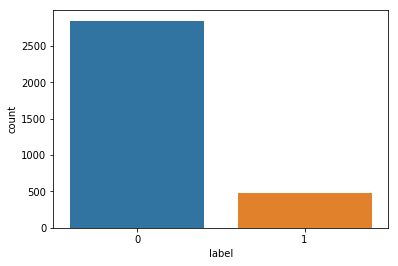

In [50]:
sns.countplot(data=df_treino_pandas,x='label')

In [65]:
x = float(major_df.count()) / minor_df.count()
x

5.900621118012422

In [69]:
# Corrigindo a proporção dos labels
# https://medium.com/@junwan01/oversampling-and-undersampling-with-pyspark-5dbc25cdf253
# https://elitedatascience.com/imbalanced-classes
minor_df = df_treino_6.filter(col("label") == 1)
major_df = df_treino_6.filter(col("label") == 0)
# Calcula quantas x tem que aumentar 1 pra ficar igual 0
x = (major_df.count() / minor_df.count()) - 1
oversampled_df = minor_df.sample(True, x)
df_treino_7 = major_df.union(oversampled_df).union(minor_df)
df_treino_7.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[128.0,415.0,0.0,...|
|    0|[107.0,415.0,0.0,...|
|    0|[137.0,415.0,0.0,...|
|    0|[84.0,408.0,0.0,1...|
|    0|[75.0,415.0,0.0,1...|
|    0|[118.0,510.0,0.0,...|
|    0|[121.0,510.0,0.0,...|
|    0|[147.0,415.0,0.0,...|
|    0|[117.0,408.0,0.0,...|
|    0|[141.0,415.0,0.0,...|
|    0|[74.0,415.0,0.0,0...|
|    0|[168.0,408.0,0.0,...|
|    0|[95.0,510.0,0.0,0...|
|    0|[62.0,415.0,0.0,0...|
|    0|[85.0,408.0,0.0,0...|
|    0|[93.0,510.0,0.0,0...|
|    0|[76.0,510.0,0.0,0...|
|    0|[73.0,415.0,0.0,0...|
|    0|[147.0,415.0,0.0,...|
|    0|[130.0,415.0,0.0,...|
+-----+--------------------+
only showing top 20 rows



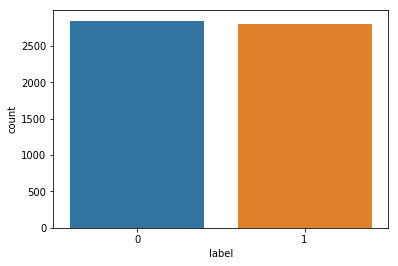

In [70]:
df_treino_pandas = df_treino_7.toPandas()
sns.countplot(data=df_treino_pandas,x='label')

In [72]:
# Treinamento e criação do modelo
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
modelo = rf.fit(df_treino_7)

In [73]:
modelo.featureImportances

SparseVector(20, {0: 0.0005, 2: 0.7097, 3: 0.0466, 4: 0.0899, 5: 0.0098, 6: 0.0006, 7: 0.0815, 8: 0.0173, 9: 0.0002, 10: 0.0091, 11: 0.007, 12: 0.0064, 13: 0.0023, 14: 0.0102, 15: 0.0013, 16: 0.001, 17: 0.0016, 18: 0.0044, 19: 0.0006})

In [78]:
# Realiza mesmo tratamento para os dados de teste
df_teste = df_teste.select('*',
                               trata_ID_udf(df_teste.ID).alias("new_ID"),
                               when(df_teste.international_plan == '"no"', 0).otherwise(1).alias("new_international_plan"),
                               when(df_teste.voice_mail_plan == '"no"', 0).otherwise(1).alias("new_voice_mail_plan"),
                               when(df_teste.churn == '"no"', 0).otherwise(1).alias("new_churn"),
                               trata_area_code_udf(df_teste.area_code).alias("new_area_code"),
                              ).drop('area_code').drop('voice_mail_plan').drop('international_plan').drop('ID').drop('churn').withColumnRenamed('new_international_plan','international_plan').withColumnRenamed('new_voice_mail_plan','voice_mail_plan').withColumnRenamed('new_area_code','area_code').withColumnRenamed('new_ID','ID').withColumnRenamed('new_churn','churn')


df_teste = df_teste.select(
                            *(
                                col(column).cast("float").alias(column)
                                if ('minutes' in column or 'charge' in column)
                                else ( col(column).cast("string").alias(column)
                                        if 'state' in column
                                        else col(column).cast("integer").alias(column) 
                                 )
                                for column
                                in df_teste.columns
                              )
)

indexer = StringIndexer(inputCol="state", outputCol="state_2")
df_teste = indexer.fit(df_teste).transform(df_teste).drop('state').withColumnRenamed('state_2','state')

df_teste = df_teste[columns]

rddLabeled = df_teste.rdd.map(transformaVar)

df_teste = spSession.createDataFrame(rddLabeled,["label", "features"])

In [79]:
# Previsões com dados de teste
predictions = modelo.transform(df_teste)
predictions.select("features", "prediction", "label").show()

+--------------------+----------+-----+
|            features|prediction|label|
+--------------------+----------+-----+
|[101.0,510.0,0.0,...|       0.0|    0|
|[137.0,510.0,0.0,...|       0.0|    0|
|[103.0,408.0,0.0,...|       0.0|    0|
|[99.0,415.0,0.0,0...|       0.0|    0|
|[108.0,415.0,0.0,...|       0.0|    0|
|[117.0,415.0,0.0,...|       0.0|    0|
|[63.0,415.0,0.0,0...|       0.0|    0|
|[94.0,408.0,0.0,0...|       0.0|    0|
|[138.0,510.0,0.0,...|       0.0|    0|
|[128.0,415.0,0.0,...|       0.0|    0|
|[113.0,510.0,0.0,...|       0.0|    0|
|[140.0,415.0,0.0,...|       0.0|    0|
|[102.0,415.0,0.0,...|       0.0|    0|
|[108.0,415.0,0.0,...|       0.0|    0|
|[60.0,408.0,0.0,0...|       0.0|    0|
|[96.0,408.0,0.0,0...|       0.0|    0|
|[178.0,415.0,0.0,...|       0.0|    0|
|[75.0,415.0,0.0,0...|       0.0|    0|
|[106.0,415.0,0.0,...|       0.0|    0|
|[158.0,510.0,0.0,...|       0.0|    0|
+--------------------+----------+-----+
only showing top 20 rows



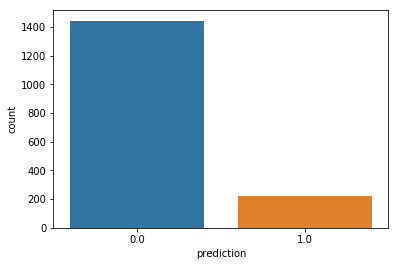

In [80]:
df_predictions_pandas = predictions.toPandas()
sns.countplot(data=df_predictions_pandas,x='prediction')

In [81]:
# Acurácia
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % (accuracy))
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 1
Test Error = 0
